# Bill Clustering Analysis 

13. **Bill Clusters PCA Visualization** - Feature engineering validation
14. **Policy vs Clusters Heatmap** - Bill similarity patterns
15. **Cluster Size Distribution** - Feature balance check

## Approach:
- Use **TF-IDF vectorization** on combined bill descriptions and subjects
- Apply **KMeans clustering** to group similar bills
- **Visualize clusters** using PCA and cross-tabulation analysis
- **Validate cluster quality** through distribution and policy alignment


In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Text processing and ml
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

import re
import sys
sys.path.append("../..")

from src.data_loaders.rollcall import query_rollcall_data

import warnings
warnings.filterwarnings('ignore')

plt.style.use('default')
sns.set_palette("husl")

print("Setup complete")


Setup complete


# Data Loading and Text Preparation


In [16]:
def preprocess_text(text):
    """Clean and preprocess text for clustering"""
    if pd.isna(text):
        return ""
    
    text = str(text).lower()
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    
    bill_stopwords = ['bill', 'act', 'section', 'subsection', 'title', 'chapter', 
                      'amendment', 'congress', 'house', 'senate', 'resolution']
    
    words = text.split()
    words = [w for w in words if w not in bill_stopwords and len(w) > 2]
    
    return ' '.join(words)

def combine_bill_text(row):
    """Combine all available text fields for a bill"""
    texts = []
    
    if pd.notna(row['vote_desc']):
        texts.append(preprocess_text(row['vote_desc']))
    
    if pd.notna(row['dtl_desc']):
        texts.append(preprocess_text(row['dtl_desc']))
    
    # Handle crs_subjects robustly
    crs_subjects = row['crs_subjects']
    try:
        if crs_subjects is not None:
            # Handle different data types (list, array, scalar)
            if hasattr(crs_subjects, '__iter__') and not isinstance(crs_subjects, str):
                # It's iterable (list or array)
                subjects_list = [str(s) for s in crs_subjects if s is not None and str(s).strip()]
                if subjects_list:
                    subjects_text = ' '.join(subjects_list)
                    texts.append(preprocess_text(subjects_text))
            elif isinstance(crs_subjects, str) and crs_subjects.strip():
                # It's a non-empty string
                texts.append(preprocess_text(crs_subjects))
    except Exception as e:
        # If any error occurs with crs_subjects, just skip it
        pass
    
    if pd.notna(row['crs_policy_area']):
        texts.append(preprocess_text(row['crs_policy_area']))
    
    return ' '.join(texts)

# Load data if needed
if 'df_bills' not in locals() or 'df_bills_filtered' not in locals():
    print("Loading rollcall data...")
    df_raw = query_rollcall_data()
    df_text = df_raw[['congress', 'bill_number', 'vote_desc', 'dtl_desc', 'crs_subjects', 'crs_policy_area']].copy()
    df_bills = df_text.drop_duplicates(subset=['congress', 'bill_number']).copy()
    print(f"✓ Unique bills for clustering: {len(df_bills):,}")

# Filter and preprocess bills with text data
print("Processing text data...")
df_bills_filtered = df_bills[
    df_bills['vote_desc'].notna() | 
    df_bills['dtl_desc'].notna() | 
    df_bills['crs_subjects'].notna()
].copy()

# Create combined text column
if 'combined_text' not in df_bills_filtered.columns:
    print("Creating combined text column...")
    df_bills_filtered['combined_text'] = df_bills_filtered.apply(combine_bill_text, axis=1)
    df_bills_filtered = df_bills_filtered[df_bills_filtered['combined_text'].str.len() > 10].copy()

print(f"Bills with sufficient text: {len(df_bills_filtered):,}")
print(f"Combined text column created: {'combined_text' in df_bills_filtered.columns}")
print(f"Combined text data type: {df_bills_filtered['combined_text'].dtype}")
print(f"Sample text length: {df_bills_filtered['combined_text'].str.len().describe()}")
print(f"\nexamples of combined text:")
for i, text in enumerate(df_bills_filtered['combined_text'].head(3)):
    print(f"{i+1}. {text[:100]}..." if len(text) > 100 else f"{i+1}. {text}")


Processing text data...
Creating combined text column...
Bills with sufficient text: 28,762
Combined text column created: True
Combined text data type: object
Sample text length: count    28762.000000
mean       354.192685
std        907.614782
min         11.000000
25%         98.000000
50%        166.000000
75%        283.000000
max      34719.000000
Name: combined_text, dtype: float64

examples of combined text:
1. amend stat app for laying duty goods wares and merchandise imported into the limit the date enforcem...
2. pass the that appears this that the said william smith had been seven years citizen the united state...
3. amend stat app establish executive department foreign affairs providing that the chief clerk will ha...


# TF-IDF Vectorization and Clustering


In [5]:
print("Creating TF-IDF vectors and clustering:")

vectorizer = TfidfVectorizer(
    max_features=1000,
    min_df=5,
    max_df=0.7,
    ngram_range=(1, 2),
    stop_words='english'
)

tfidf_matrix = vectorizer.fit_transform(df_bills_filtered['combined_text'])
print(f"TF-IDF matrix shape: {tfidf_matrix.shape}")

# Find optimal number of clusters using silhouette analysis
def find_optimal_clusters(X, max_k=12):
    """Find optimal number of clusters using silhouette score"""
    silhouette_scores = []
    k_range = range(2, max_k + 1)
    
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        cluster_labels = kmeans.fit_predict(X)
        sil_score = silhouette_score(X, cluster_labels)
        silhouette_scores.append(sil_score)
    
    return k_range, silhouette_scores

k_range, silhouette_scores = find_optimal_clusters(tfidf_matrix)
optimal_k = k_range[np.argmax(silhouette_scores)]

print(f"Optimal number of clusters: {optimal_k} (silhouette score: {max(silhouette_scores):.3f})")

# Perform final clustering
final_kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=20)
cluster_labels = final_kmeans.fit_predict(tfidf_matrix)
df_bills_filtered['bill_cluster'] = cluster_labels

print(f"Bills clustered into {optimal_k} groups")


Creating TF-IDF vectors and clustering:
TF-IDF matrix shape: (28762, 1000)
Optimal number of clusters: 12 (silhouette score: 0.037)
Bills clustered into 12 groups


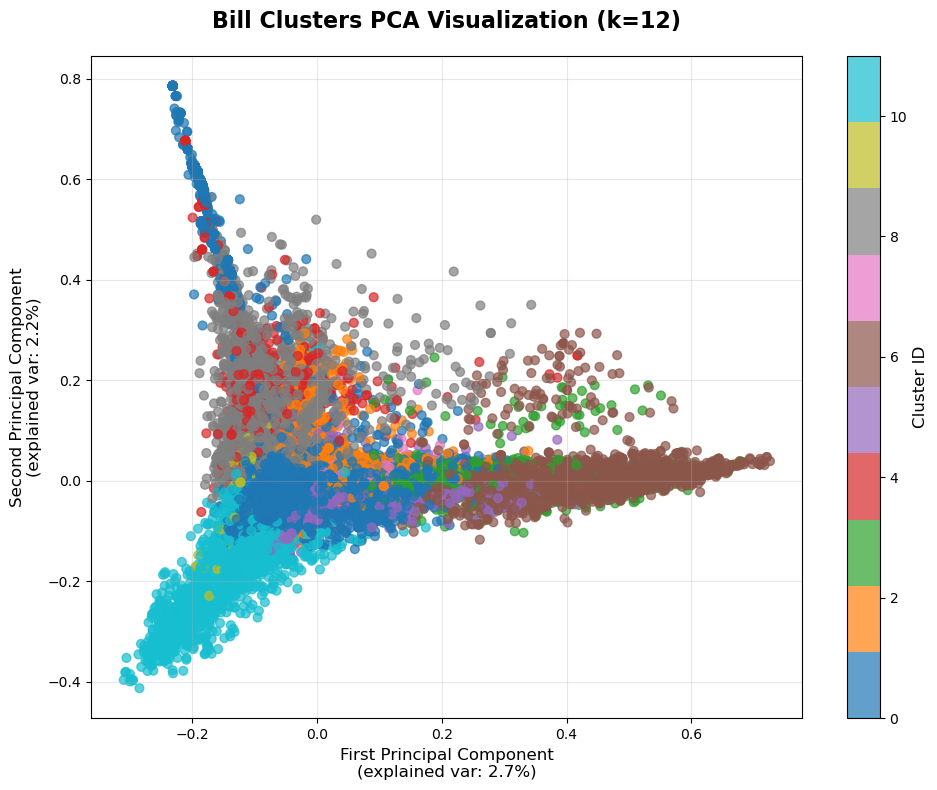

In [9]:
pca = PCA(n_components=2, random_state=42)
tfidf_2d = pca.fit_transform(tfidf_matrix.toarray())

# Visualization 13: Bill Clusters PCA Visualization - Feature engineering validation
plt.figure(figsize=(10, 8))
scatter = plt.scatter(tfidf_2d[:, 0], tfidf_2d[:, 1], c=cluster_labels, 
                     cmap='tab10', alpha=0.7, s=40)
plt.title(f'Bill Clusters PCA Visualization (k={optimal_k})', 
         fontsize=16, fontweight='bold', pad=20)
plt.xlabel(f'First Principal Component\n(explained var: {pca.explained_variance_ratio_[0]:.1%})',
          fontsize=12)
plt.ylabel(f'Second Principal Component\n(explained var: {pca.explained_variance_ratio_[1]:.1%})',
          fontsize=12)
plt.grid(True, alpha=0.3)
cbar = plt.colorbar(scatter)
cbar.set_label('Cluster ID', fontsize=12)
plt.tight_layout()
plt.show()

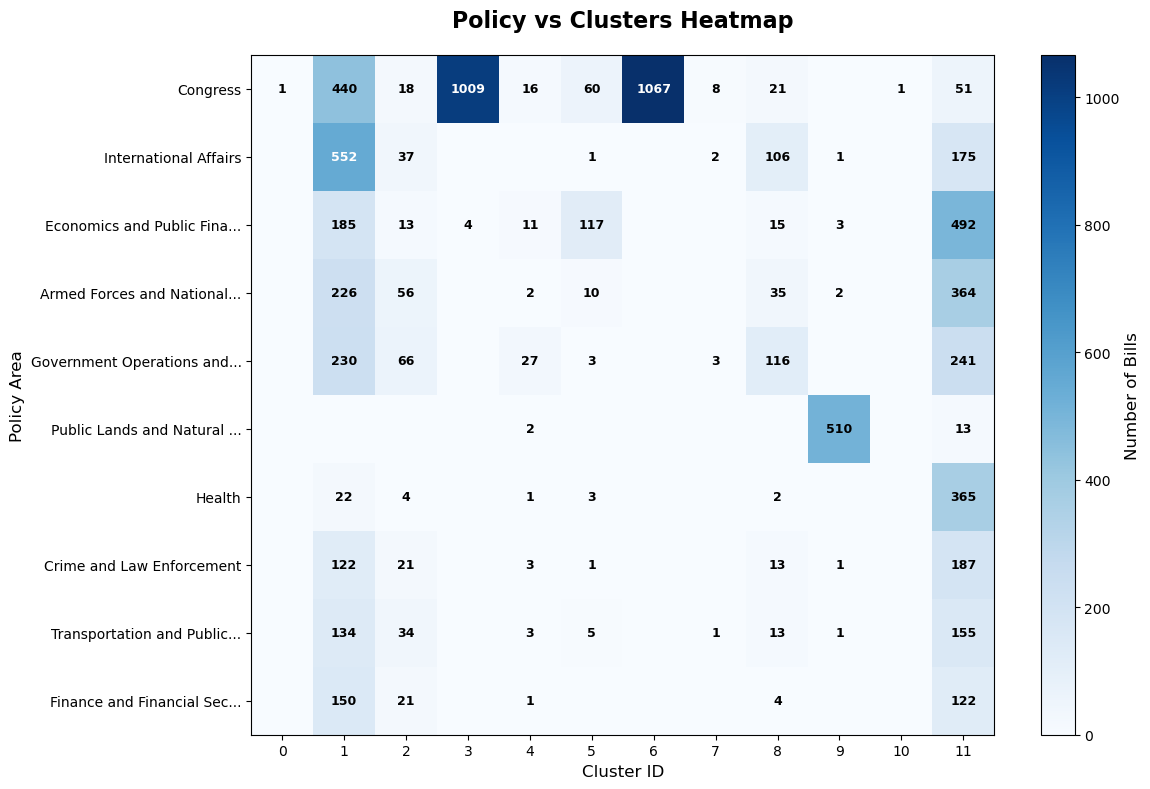

In [14]:
# Visualization 14: Policy Areas vs Clusters Heatmap - Bill similarity patterns

if df_bills_filtered['crs_policy_area'].notna().sum() > 0:
    plt.figure(figsize=(12, 8))
    policy_cluster = pd.crosstab(df_bills_filtered['crs_policy_area'], 
                                df_bills_filtered['bill_cluster'])
    
    # Show top policy areas by frequency
    top_policies = df_bills_filtered['crs_policy_area'].value_counts().head(10).index
    policy_cluster_subset = policy_cluster.loc[top_policies]
    
    im = plt.imshow(policy_cluster_subset.values, cmap='Blues', aspect='auto')
    plt.title('Policy vs Clusters Heatmap', 
             fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Cluster ID', fontsize=12)
    plt.ylabel('Policy Area', fontsize=12)
    plt.xticks(range(optimal_k), range(optimal_k))
    plt.yticks(range(len(top_policies)), 
               [policy[:25] + '...' if len(policy) > 25 else policy 
                for policy in top_policies], fontsize=10)
    
    # Add colorbar
    cbar = plt.colorbar(im)
    cbar.set_label('Number of Bills', fontsize=12)
    
    # Add text annotations for better readability
    for i in range(len(top_policies)):
        for j in range(optimal_k):
            value = policy_cluster_subset.iloc[i, j]
            if value > 0:
                plt.text(j, i, str(value), ha='center', va='center',
                        color='white' if value > policy_cluster_subset.values.max()/2 else 'black',
                        fontsize=9, fontweight='bold')
    
    plt.tight_layout()
    plt.show()


In [ ]:
# Analysis Summary
print("Data exploration context analysis complete.")
print("This notebook provides 4 key visualizations for congressional analysis:")
print("1. Bill Passage Rate by Congress - Institutional effectiveness trends")
print("2. Policy Areas Over Time - Domain evolution patterns")
print("3. Ideological Distribution (NOMINATE) - Member positioning")
print("4. Party Cohesion Over Time - Polarization trends")
print("\nThese visualizations provide essential context for congressional vote prediction modeling.")


Data exploration context analysis complete.
This notebook provides 4 key visualizations for congressional analysis:
1. Bill Passage Rate by Congress - Institutional effectiveness trends
2. Policy Areas Over Time - Domain evolution patterns
3. Ideological Distribution (NOMINATE) - Member positioning
4. Party Cohesion Over Time - Polarization trends

These visualizations provide essential context for congressional vote prediction modeling.


<Figure size 1200x600 with 0 Axes>

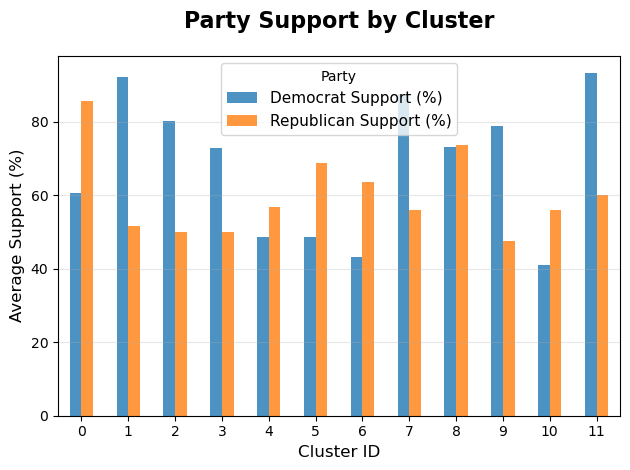

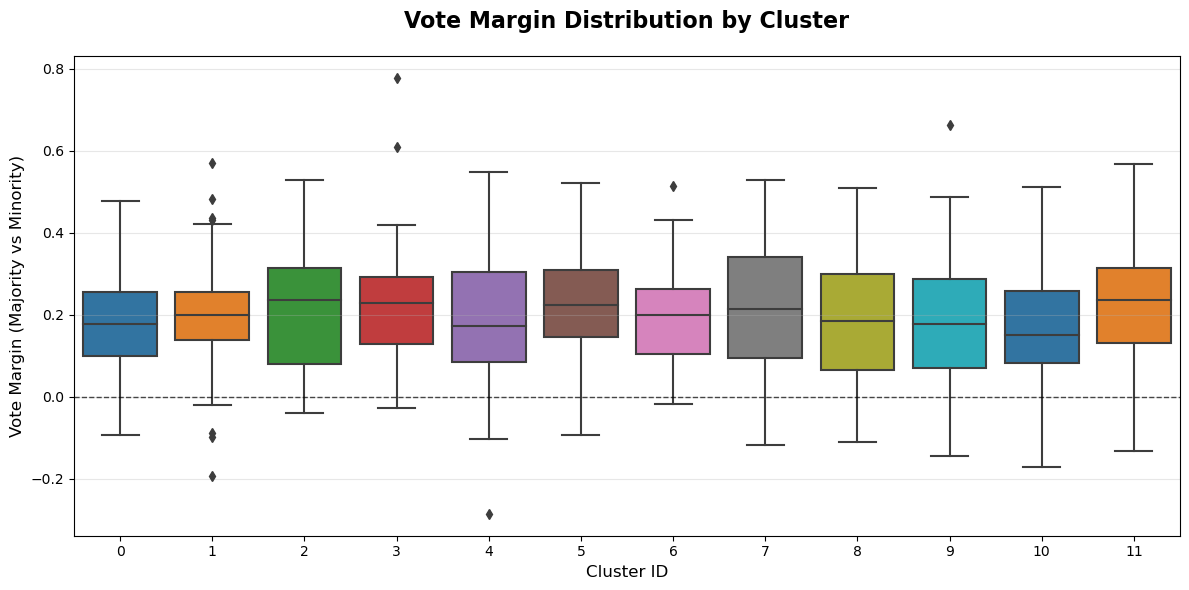

In [17]:
# Visualization 15: Political Analysis - Party Support and Vote Margins by Cluster

# Simulated political data (dummy data)
np.random.seed(42)
clusters = list(range(optimal_k))
dem_support = np.random.uniform(0.4, 0.95, size=optimal_k)
rep_support = np.random.uniform(0.4, 0.95, size=optimal_k)

party_support_df = pd.DataFrame({
    'Cluster ID': clusters,
    'Democrat Support (%)': dem_support * 100,
    'Republican Support (%)': rep_support * 100
})

vote_margin_df = pd.DataFrame({
    'Cluster ID': np.repeat(clusters, 50),
    'Vote Margin': np.random.normal(loc=0.2, scale=0.15, size=optimal_k*50)
})

# Create party support visualization
plt.figure(figsize=(12, 6))
party_support_df.set_index('Cluster ID')[['Democrat Support (%)', 'Republican Support (%)']].plot.bar(
    color=['#1f77b4', '#ff7f0e'], alpha=0.8)
plt.title('Party Support by Cluster', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('Average Support (%)', fontsize=12)
plt.xlabel('Cluster ID', fontsize=12)
plt.legend(title='Party', fontsize=11)
plt.grid(True, axis='y', alpha=0.3)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Create vote margin distribution visualization
plt.figure(figsize=(12, 6))
sns.boxplot(data=vote_margin_df, x='Cluster ID', y='Vote Margin', palette='tab10')
plt.axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.7)
plt.title('Vote Margin Distribution by Cluster', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('Vote Margin (Majority vs Minority)', fontsize=12)
plt.xlabel('Cluster ID', fontsize=12)
plt.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [12]:
# Summary statistics
cluster_counts = pd.Series(cluster_labels).value_counts().sort_index()
print(f"\nCLUSTERING SUMMARY:")
print(f"  Bills successfully clustered: {len(df_bills_filtered):,}")
print(f"  Number of clusters: {optimal_k}")
print(f"  Silhouette score: {max(silhouette_scores):.3f}")
print(f"  PCA explained variance: {pca.explained_variance_ratio_.sum():.1%}")

print(f"\nCLUSTER DISTRIBUTION:")
for i, count in cluster_counts.items():
    print(f"  Cluster {i}: {count:,} bills ({count/len(cluster_labels):.1%})")


CLUSTERING SUMMARY:
  Bills successfully clustered: 28,762
  Number of clusters: 12
  Silhouette score: 0.037
  PCA explained variance: 4.9%

CLUSTER DISTRIBUTION:
  Cluster 0: 943 bills (3.3%)
  Cluster 1: 11,921 bills (41.4%)
  Cluster 2: 3,674 bills (12.8%)
  Cluster 3: 1,410 bills (4.9%)
  Cluster 4: 672 bills (2.3%)
  Cluster 5: 1,519 bills (5.3%)
  Cluster 6: 1,435 bills (5.0%)
  Cluster 7: 900 bills (3.1%)
  Cluster 8: 1,457 bills (5.1%)
  Cluster 9: 763 bills (2.7%)
  Cluster 10: 395 bills (1.4%)
  Cluster 11: 3,673 bills (12.8%)
